In [1]:
#Allow for 100% column width to take advantage of my monitor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Dependencies
import numpy as np

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [4]:
# Create our session (link) from Python to the DB
session = Session(engine)

session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f34dd5c7400>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

## D1: Determine the Summary Statistics for June

In [5]:
# 1. Import the sqlalchemy extract function.
from sqlalchemy import extract

# 2. Write a query that filters the Measurement table to retrieve the temperatures for the month of June. 
results = session.query(Measurement.tobs).filter(extract('month', Measurement.date)==6).all()

In [6]:
#  3. Convert the June temperatures to a list.
#### Results are already a list.
print(type(results))
#june_temps = list(np.ravel(results))

<class 'list'>


In [7]:
# 4. Create a DataFrame from the list of temperatures for the month of June. 
import pandas as pd
june_df = pd.DataFrame(results, columns=['June Temps'])

In [8]:
# 5. Calculate and print out the summary statistics for the June temperature DataFrame.
june_df.describe()

,June Temps
count,1700.000000
mean,74.944118
std,3.257417
min,64.000000
25%,73.000000
50%,75.000000
75%,77.000000
max,85.000000


## D2: Determine the Summary Statistics for December

In [9]:
# 6. Write a query that filters the Measurement table to retrieve the temperatures for the month of December.
results = session.query(Measurement.tobs).filter(extract('month', Measurement.date)==12).all()

In [10]:
# 7. Convert the December temperatures to a list.
#### Results are already a list.
print(type(results))
# december_temps = list(np.ravel(results))

<class 'list'>


In [11]:
# 8. Create a DataFrame from the list of temperatures for the month of December. 
december_df = pd.DataFrame(results, columns=['December Temps'])

In [12]:
# 9. Calculate and print out the summary statistics for the Decemeber temperature DataFrame.
december_df.describe()

,December Temps
count,1517.000000
mean,71.041529
std,3.745920
min,56.000000
25%,69.000000
50%,71.000000
75%,74.000000
max,83.000000


## D3: Two additional Queries

In [13]:
#Average Temp query grouped by year and station 
results = session.query(Measurement.station, Measurement.date, (func.sum(Measurement.tobs) / func.count(Measurement.tobs)) ).filter(extract('month', Measurement.date)==6).group_by(extract('year', Measurement.date), Measurement.station).all()
june_df = pd.DataFrame(results, columns=['Station', 'Date', 'Tobs'])
june_df.describe()
june_df
print(session.query(Measurement.date, func.sum(Measurement.prcp)).filter(extract('month', Measurement.date)==6).group_by(extract('year', Measurement.date)))

SELECT measurement.date AS measurement_date, sum(measurement.prcp) AS sum_1 
FROM measurement 
WHERE CAST(STRFTIME('%m', measurement.date) AS INTEGER) = ? GROUP BY CAST(STRFTIME('%Y', measurement.date) AS INTEGER)


        Station  Year       Tobs
43  USC00511918  2015  70.157895
12  USC00516128  2011  70.733333
21  USC00516128  2012  70.964286
30  USC00516128  2013  71.200000
46  USC00516128  2015  71.620690
..          ...   ...        ...
61  USC00517948  2017  78.600000
47  USC00517948  2015  78.692308
59  USC00514830  2017  78.875000
64  USC00519523  2017  78.896552
63  USC00519397  2017  79.200000

[65 rows x 3 columns]


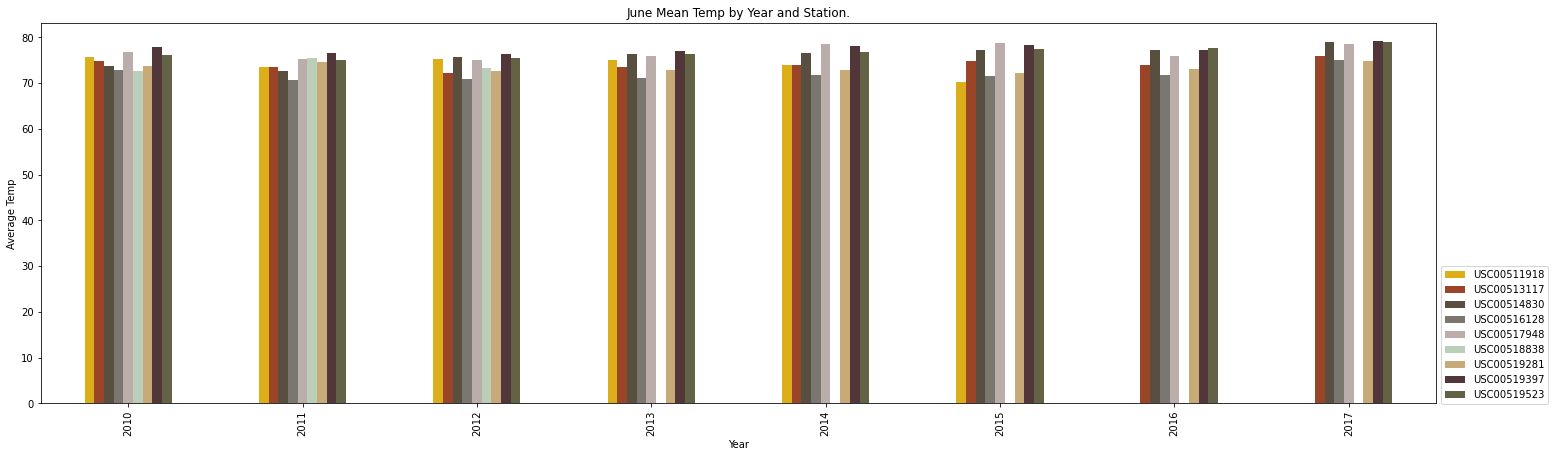

In [14]:
#graph results of Precipitation query grouped by year and station 
%matplotlib inline
import matplotlib.pyplot as plt
june_df = june_df.sort_values(by=['Tobs', 'Date'],ascending=True)
# Convert Date Column to datetime type and consolidate into years
june_df['Date'] = pd.to_datetime(june_df['Date'])
june_df['Date'] = pd.DatetimeIndex(june_df['Date']).year
#Rename Date Column
june_df = june_df.rename(columns={"Date": "Year"})
# Begin Plot
fig, ax = plt.subplots(figsize=(25,7))
ax.set_title('June Mean Temp by Year and Station.')
ax.set(xlabel='Year', ylabel='Average Temp')

#Define my own color set.
color_list=[
    '#DCAF1A', '#9B4528', '#594F40', '#7A7670', '#BBAEAA', '#BACEB9',
    '#C8AA78', '#51373A', '#636244', '#C74958']

#Set custom color cycler
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

#turn off grid lines for x axis
#ax.get_xaxis().set_visible(False)

# use unstack()
june_df.groupby(['Year','Station']).mean()['Tobs'].unstack().plot(kind='bar', stacked=False, ax=ax).legend(bbox_to_anchor=(1, 0.375))

print(june_df)

In [15]:
#Additional Queries precipitation
results = session.query(Measurement.prcp).filter(extract('month', Measurement.date)==6).all()
june_df = pd.DataFrame(results, columns=['June Precipitation'])
june_df.describe()

,June Precipitation
count,1574.000000
mean,0.136360
std,0.335731
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,4.430000


In [16]:
#Precipitation query grouped by year and station 
results = session.query(Measurement.station, Measurement.date, func.sum(Measurement.prcp)).filter(extract('month', Measurement.date)==6).group_by(extract('year', Measurement.date), Measurement.station).all()
june_df = pd.DataFrame(results, columns=['Station', 'Date', 'Precipitation'])
june_df.describe()
print(session.query(Measurement.date, func.sum(Measurement.prcp)).filter(extract('month', Measurement.date)==6).group_by(extract('year', Measurement.date)))

SELECT measurement.date AS measurement_date, sum(measurement.prcp) AS sum_1 
FROM measurement 
WHERE CAST(STRFTIME('%m', measurement.date) AS INTEGER) = ? GROUP BY CAST(STRFTIME('%Y', measurement.date) AS INTEGER)


        Station  Year  Precipitation
0   USC00511918  2010           0.30
1   USC00513117  2010           0.86
2   USC00514830  2010           0.73
3   USC00516128  2010           4.40
4   USC00517948  2010           0.33
5   USC00518838  2010           1.22
6   USC00519281  2010           1.59
7   USC00519397  2010           0.03
8   USC00519523  2010           0.34
9   USC00511918  2011           0.93
10  USC00513117  2011          11.00
11  USC00514830  2011           7.84
12  USC00516128  2011          18.99
13  USC00517948  2011           2.41
14  USC00518838  2011           1.21
15  USC00519281  2011           4.42
16  USC00519397  2011           1.76
17  USC00519523  2011           2.35
18  USC00511918  2012           0.21
19  USC00513117  2012           1.63
20  USC00514830  2012           0.69
21  USC00516128  2012          11.06
22  USC00517948  2012           0.36
23  USC00518838  2012           0.03
24  USC00519281  2012           2.92
25  USC00519397  2012           0.28
2

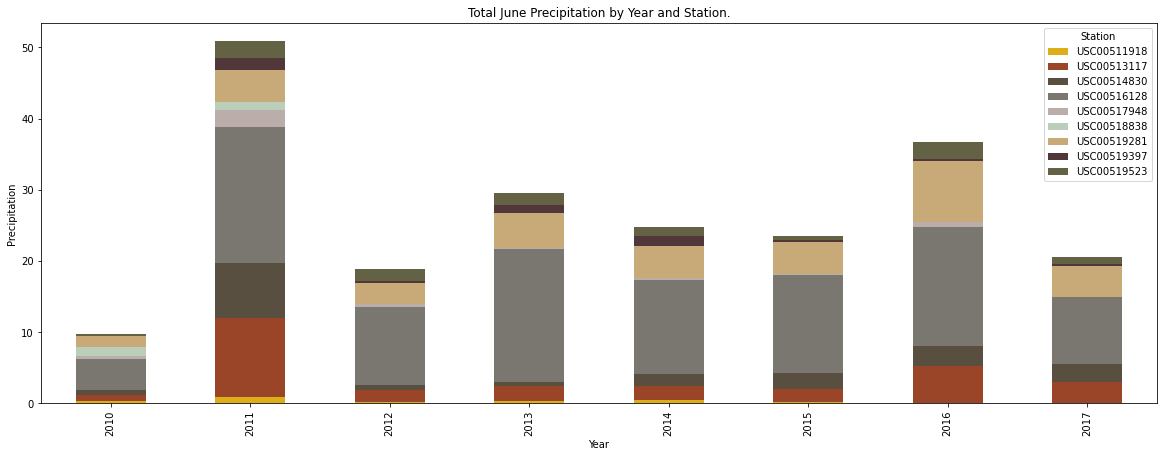

In [17]:
#graph results of Precipitation query grouped by year and station 
%matplotlib inline
import matplotlib.pyplot as plt
june_df = june_df.sort_values(by=['Station', 'Date'],ascending=True)
# Convert Date Column to datetime type and consolidate into years
june_df['Date'] = pd.to_datetime(june_df['Date'])
june_df['Date'] = pd.DatetimeIndex(june_df['Date']).year
#Rename Date Column
june_df = june_df.rename(columns={"Date": "Year"})
# Begin Plot
fig, ax = plt.subplots(figsize=(20,7))
ax.set_title('Total June Precipitation by Year and Station.')
ax.set(xlabel='Year', ylabel='Precipitation')
#Define my own color set.
color_list=[
    '#DCAF1A', '#9B4528', '#594F40', '#7A7670', '#BBAEAA', '#BACEB9',
    '#C8AA78', '#51373A', '#636244', '#C74958']

#Set custom color cycler
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
#turn off grid lines for x axis
#ax.get_xaxis().set_visible(False)

# use unstack()
june_df.groupby(['Year','Station']).sum()['Precipitation'].unstack().plot(kind='bar', stacked=True, ax=ax)

june_df.sort_index(inplace=True)
print(june_df.to_string())

In [18]:
#Additional Queries precipitation
results = session.query(Measurement.prcp).filter(extract('month', Measurement.date)==12).all()
december_df = pd.DataFrame(results, columns=['December Precipitation'])
december_df.describe()

,December Precipitation
count,1405.000000
mean,0.216819
std,0.541399
min,0.000000
25%,0.000000
50%,0.030000
75%,0.150000
max,6.420000


In [19]:
results = session.query(Measurement.station, Measurement.date, func.sum(Measurement.prcp)).filter(extract('month', Measurement.date)==12).group_by(extract('year', Measurement.date), Measurement.station).all()
december_df = pd.DataFrame(results, columns=['Station', 'Date', 'Precipitation'])
december_df.describe()
print(session.query(Measurement.date, func.sum(Measurement.prcp)).filter(extract('month', Measurement.date)==12).group_by(extract('year', Measurement.date)))

SELECT measurement.date AS measurement_date, sum(measurement.prcp) AS sum_1 
FROM measurement 
WHERE CAST(STRFTIME('%m', measurement.date) AS INTEGER) = ? GROUP BY CAST(STRFTIME('%Y', measurement.date) AS INTEGER)


        Station  Year  Precipitation
0   USC00511918  2010          14.82
1   USC00513117  2010          18.03
2   USC00514830  2010          10.07
3   USC00516128  2010          16.88
4   USC00517948  2010           2.73
5   USC00518838  2010           6.86
6   USC00519281  2010          18.56
7   USC00519397  2010           4.54
8   USC00519523  2010          13.10
9   USC00511918  2011           0.67
10  USC00513117  2011           4.24
11  USC00514830  2011           2.09
12  USC00516128  2011          21.03
13  USC00517948  2011           3.96
14  USC00519281  2011           5.97
15  USC00519397  2011           2.22
16  USC00519523  2011           3.16
17  USC00511918  2012           0.27
18  USC00513117  2012           1.75
19  USC00514830  2012           1.09
20  USC00516128  2012           8.63
21  USC00517948  2012           0.13
22  USC00518838  2012            NaN
23  USC00519281  2012           3.29
24  USC00519397  2012           0.78
25  USC00519523  2012           2.16
2

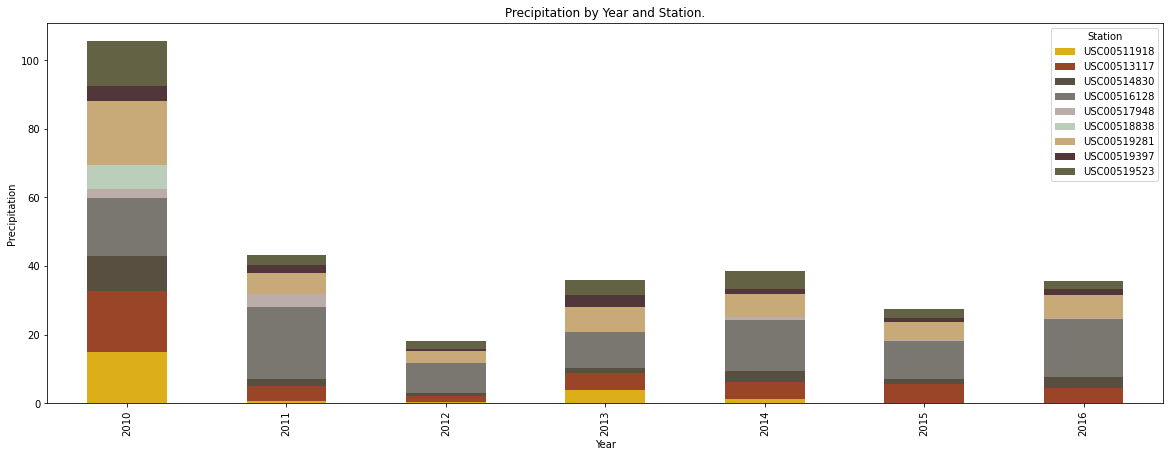

In [20]:
#graph results of Precipitation query grouped by year and station 
%matplotlib inline
import matplotlib.pyplot as plt
december_df = december_df.sort_values(by=['Station', 'Date'],ascending=True)
# Convert Date Column to datetime type and consolidate into years
december_df['Date'] = pd.to_datetime(december_df['Date'])
december_df['Date'] = pd.DatetimeIndex(december_df['Date']).year
#Rename Date Column
december_df = december_df.rename(columns={"Date": "Year"})
# Begin Plot
fig, ax = plt.subplots(figsize=(20,7))
ax.set_title('Precipitation by Year and Station.')
ax.set(xlabel='Year', ylabel='Precipitation')
#Define my own color set.
color_list=[
    '#DCAF1A', '#9B4528', '#594F40', '#7A7670', '#BBAEAA', '#BACEB9',
    '#C8AA78', '#51373A', '#636244', '#C74958']

#Set custom color cycler
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
#turn off grid lines for x axis
#ax.get_xaxis().set_visible(False)

# use unstack()
december_df.groupby(['Year','Station']).sum()['Precipitation'].unstack().plot(kind='bar', stacked=True, ax=ax)

december_df.sort_index(inplace=True)
print(december_df)

In [21]:
results = session.query(Measurement.station, func.count(Measurement.station)).filter(extract('month', Measurement.date)==6).group_by(Measurement.station).order_by(Measurement.station).all()
june_df = pd.DataFrame(results, columns=['Station', 'Count' ])
print(june_df)
print(f"========================")
print(f"Total Station Count {june_df.Count.sum()}")

       Station  Count
0  USC00511918    165
1  USC00513117    236
2  USC00514830    186
3  USC00516128    223
4  USC00517948    148
5  USC00518838     38
6  USC00519281    236
7  USC00519397    236
8  USC00519523    232
Total Station Count 1700


In [22]:
results = session.query(Measurement.station, func.count(Measurement.station)).filter(extract('month', Measurement.date)==12).group_by(Measurement.station).order_by(Measurement.station).all()
december_df = pd.DataFrame(results, columns=['Station', 'Count' ])
print(december_df)
print("========================")
print(f"Total Station Count {december_df.Count.sum()}")

       Station  Count
0  USC00511918    152
1  USC00513117    216
2  USC00514830    178
3  USC00516128    206
4  USC00517948    109
5  USC00518838     19
6  USC00519281    217
7  USC00519397    210
8  USC00519523    210
Total Station Count 1517
